# CATBoost Model Preparation


In [ ]:
#!conda install catboost -y

In [ ]:

#spark.stop()

In [1]:

# Setup Environment
import time
from optuna.importance import MeanDecreaseImpurityImportanceEvaluator
import os
import logging
import datetime
import numpy as np
import pandas as pd
import joblib # Used for encoding horse_id
from sklearn.model_selection import KFold
from sklearn.utils import shuffle
import matplotlib.pyplot as plt
import optuna
import optuna.visualization as viz
from catboost import CatBoostRanker, CatBoostRegressor, CatBoostClassifier, Pool
import catboost as cb
import numpy as np
import itertools
from sklearn.preprocessing import LabelEncoder
import pyspark.sql.functions as F
from pyspark.sql.functions import (col, count, row_number, abs, unix_timestamp, mean, 
                                   when, lit, min as F_min, max as F_max , upper, trim,
                                   row_number, mean as F_mean, countDistinct, last, first, when)
from src.data_preprocessing.data_prep1.data_utils import initialize_environment 
# Set global references to None
spark = None
master_results_df = None
race_df = None
df = None
training_data = None
train_df = None

In [3]:

spark, jdbc_url, jdbc_properties, parquet_dir, log_file = initialize_environment()


Spark session created successfully.


In [4]:
# This dataset has already been cleaned up in the LGB notebook and saved as a starting point
# It now just needs to be converted to Panadas and run in the GBDT variant model (LGB, XGB, CatBoost)
#full_data = spark.read.parquet("/home/exx/myCode/horse-racing/FoxRiverAIRacing/data/parquet/horse_embedding_data-2025-01-25-2309.parquet")
#full_data = spark.read.parquet("/home/exx/myCode/horse-racing/FoxRiverAIRacing/data/parquet/speed_figure.parquet")
full_data = spark.read.parquet("/home/exx/myCode/horse-racing/FoxRiverAIRacing/data/parquet/horse_embedding_data-2025-01-27-2038.parquet")
# full_data = spark.read.parquet("/home/exx/myCode/horse-racing/FoxRiverAIRacing/data/parquet/speed_figure.parquet")

In [5]:
full_data.printSchema()

root
 |-- axciskey: string (nullable = true)
 |-- course_cd: string (nullable = true)
 |-- race_date: date (nullable = true)
 |-- race_number: double (nullable = true)
 |-- horse_id: double (nullable = true)
 |-- horse_name: string (nullable = true)
 |-- official_fin: long (nullable = true)
 |-- time_behind: double (nullable = true)
 |-- pace_delta_time: double (nullable = true)
 |-- speed_rating: long (nullable = true)
 |-- prev_speed_rating: double (nullable = true)
 |-- previous_class: double (nullable = true)
 |-- purse: double (nullable = true)
 |-- weight: double (nullable = true)
 |-- sex: string (nullable = true)
 |-- equip: string (nullable = true)
 |-- claimprice: double (nullable = true)
 |-- surface: string (nullable = true)
 |-- distance_meters: double (nullable = true)
 |-- class_rating: double (nullable = true)
 |-- previous_distance: double (nullable = true)
 |-- previous_surface: string (nullable = true)
 |-- off_finish_last_race: long (nullable = true)
 |-- power: dou

In [6]:
full_data.count()

328184

# Switching to Pandas

In [7]:
# Convert Spark DataFrame -> Pandas DataFrame

full_data = full_data.toPandas()


In [43]:
import re
import pandas as pd

pattern = r'^[A-Z]{3}_[0-9]{4}-[0-9]{2}-[0-9]{2}_[0-9]+\.0$'

# Filter rows whose race_id does NOT match this pattern
bad_race_id_rows = full_data.loc[~full_data["race_id"].str.match(pattern)]

print("Rows that do NOT match the desired format:")
print(bad_race_id_rows[["race_id"]].head(20))

Rows that do NOT match the desired format:
Empty DataFrame
Columns: [race_id]
Index: []


# Convert DataTime columns to Numerical Values

In [9]:
import pandas as pd
import matplotlib.pyplot as plt

# Assuming training_data is your DataFrame
# Convert datetime columns to numerical
datetime_columns = ["first_race_date_5", "most_recent_race_5", "prev_race_date"]
for col in datetime_columns:
    full_data[col] = pd.to_datetime(full_data[col])
    full_data[f"{col}_numeric"] = (full_data[col] - pd.Timestamp("1970-01-01")).dt.days


# Drop the original datetime columns
full_data.drop(columns=datetime_columns, inplace=True)

# Display summary statistics for the numeric columns
print(full_data[[f"{col}_numeric" for col in datetime_columns]].describe())

# # Plot the distribution of the numeric columns
# for col in datetime_columns:
#     plt.figure(figsize=(10, 6))
#     plt.hist(full_data[f"{col}_numeric"], bins=50, edgecolor='black')
#     plt.title(f'Distribution of {col}_numeric')
#     plt.xlabel(f'{col}_numeric')
#     plt.ylabel('Frequency')
#     plt.show()

       first_race_date_5_numeric  most_recent_race_5_numeric  \
count              328184.000000               328184.000000   
mean                19427.831080                19562.968463   
std                   282.561504                  304.414004   
min                 18993.000000                18993.000000   
25%                 19181.000000                19315.000000   
50%                 19412.000000                19562.000000   
75%                 19641.000000                19826.000000   
max                 20110.000000                20110.000000   

       prev_race_date_numeric  
count           328184.000000  
mean             16463.262947  
std               7116.353853  
min                  0.000000  
25%              19140.000000  
50%              19461.000000  
75%              19734.000000  
max              20104.000000  


# Split the data - Training/Valid & Meta-Data Training by Date

In [10]:
# Let's define the date boundary for hold-out as 2024-07-01
holdout_start = "2024-07-01"

# Convert race_date if not done
full_data["race_date"] = pd.to_datetime(full_data["race_date"])

# meta_data/hold-out: from 2024-07-01 onward
meta_data = full_data[full_data["race_date"] >= holdout_start].copy()

# combined_data: everything before 2024-07-01
combined_data = full_data[full_data["race_date"] < holdout_start].copy()

print("meta_data shape:", meta_data.shape)
print("combined_data shape:", combined_data.shape)

meta_data shape: (54997, 104)
combined_data shape: (273187, 104)


# Drop Unnecssary Columns

In [11]:
cols_to_drop = ["horse_name", "horse_id", "official_fin", "saddle_cloth_number" , "group_id",
                "group_id", "dam_earnings", "sire_earnings", "date_of_birth"]

meta_data.drop(columns=cols_to_drop, inplace=True, errors="ignore")
combined_data.drop(columns=cols_to_drop, inplace=True, errors="ignore")

# Assigned Numerical & Categorical Features

In [12]:
cat_cols = [
    "course_cd", "trk_cond", "sex", "equip", "surface", "med", 
    "race_type", "stk_clm_md", "turf_mud_mark", "layoff_cat", "previous_surface"
]

label_col = "perf_target"  # The finishing position or performance measure

In [16]:
numeric_cols = [
    col for col in combined_data.columns
    if combined_data[col].dtype in ["float64", "int64"] and col not in ["perf_target", "group_id"]
]

# Add embedding columns explicitly
embed_cols = [f"embed_{i}" for i in range(4)]
numeric_cols.extend(embed_cols)

# Final numeric columns
print("Numerical Columns for Training:", numeric_cols)

Numerical Columns for Training: ['race_number', 'time_behind', 'pace_delta_time', 'speed_rating', 'prev_speed_rating', 'previous_class', 'purse', 'weight', 'claimprice', 'distance_meters', 'class_rating', 'previous_distance', 'off_finish_last_race', 'power', 'morn_odds', 'avgspd', 'starts', 'net_sentiment', 'avg_spd_sd', 'ave_cl_sd', 'hi_spd_sd', 'pstyerl', 'all_starts', 'all_win', 'all_place', 'all_show', 'all_fourth', 'all_earnings', 'horse_itm_percentage', 'cond_starts', 'cond_win', 'cond_place', 'cond_show', 'cond_fourth', 'cond_earnings', 'jock_win_percent', 'jock_itm_percent', 'trainer_win_percent', 'trainer_itm_percent', 'jt_win_percent', 'jt_itm_percent', 'jock_win_track', 'jock_itm_track', 'trainer_win_track', 'trainer_itm_track', 'jt_win_track', 'jt_itm_track', 'sire_itm_percentage', 'sire_roi', 'dam_itm_percentage', 'dam_roi', 'total_races_5', 'avg_fin_5', 'avg_speed_5', 'best_speed', 'avg_beaten_len_5', 'avg_dist_bk_gate1_5', 'avg_dist_bk_gate2_5', 'avg_dist_bk_gate3_5', 'a

In [18]:
#print(combined_data)

# No Encoding of cat_cols -- just check for NaNs

In [19]:

for c in cat_cols:
    combined_data[c] = combined_data[c].astype(str).fillna("Missing")
    meta_data[c] = meta_data[c].astype(str).fillna("Missing")

In [20]:

# Display all columns with their data types and null status
#combined_data.info(verbose=True)

# Group and sort data by race_id and group_id

In [21]:
combined_data.rename(columns={"race_id": "group_id"}, inplace=True)
meta_data.rename(columns={"race_id": "group_id"}, inplace=True)

combined_data.sort_values(by=["group_id"], ascending=True, inplace=True)
meta_data.sort_values(by=["group_id"], ascending=True, inplace=True)

In [23]:
# In the holdout DataFrame
one_item_race = meta_data[meta_data["group_id"] == 20512]
print(one_item_race)

Empty DataFrame
Columns: [axciskey, course_cd, race_date, race_number, time_behind, pace_delta_time, speed_rating, prev_speed_rating, previous_class, purse, weight, sex, equip, claimprice, surface, distance_meters, class_rating, previous_distance, previous_surface, off_finish_last_race, power, trk_cond, med, morn_odds, avgspd, starts, race_type, net_sentiment, stk_clm_md, turf_mud_mark, avg_spd_sd, ave_cl_sd, hi_spd_sd, pstyerl, all_starts, all_win, all_place, all_show, all_fourth, all_earnings, horse_itm_percentage, cond_starts, cond_win, cond_place, cond_show, cond_fourth, cond_earnings, jock_win_percent, jock_itm_percent, trainer_win_percent, trainer_itm_percent, jt_win_percent, jt_itm_percent, jock_win_track, jock_itm_track, trainer_win_track, trainer_itm_track, jt_win_track, jt_itm_track, sire_itm_percentage, sire_roi, dam_itm_percentage, dam_roi, total_races_5, avg_fin_5, avg_speed_5, best_speed, avg_beaten_len_5, avg_dist_bk_gate1_5, avg_dist_bk_gate2_5, avg_dist_bk_gate3_5, avg

# perf_target Distribution

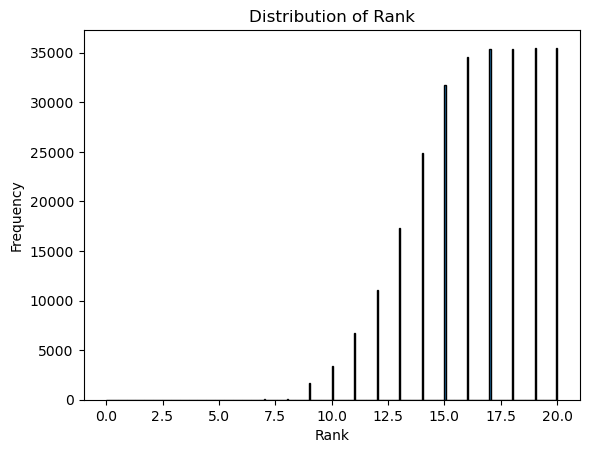

In [24]:
import pandas as pd
import matplotlib.pyplot as plt

# Assuming training_data is your DataFrame
# Plot the distribution of the 'rank' column
combined_data["perf_target"].plot(kind='hist', bins=400, edgecolor='black')
plt.title('Distribution of Rank')
plt.xlabel('Rank')
plt.ylabel('Frequency')
plt.show()

# Split Combined Data Into Train/Valid

Split combined_data (which covers 2022-01-01 through 2024-06-30) into two parts:

	•	train_data up to 2023-12-31
	•	valid_data from 2024-01-01 to 2024-06-30

In [25]:
train_end_date = "2023-12-31"
valid_data_end_date = "2024-06-30"

# Alternatively, you may have separate logic if combined_data is already filtered 
# by date. We assume "combined_data" only goes up to 2024-06-30, so you might do
train_data = combined_data[combined_data["race_date"] <= train_end_date]
valid_data = combined_data[combined_data["race_date"] > train_end_date]

print("Train shape:", train_data.shape)
print("Valid shape:", valid_data.shape)

Train shape: (214541, 100)
Valid shape: (58646, 100)


In [26]:
# train_data=train_data.drop(columns=["race_date"], errors="ignore")
# valid_data=valid_data.drop(columns=["race_date"], errors="ignore")
# meta_data=meta_data.drop(columns=["race_date"], errors="ignore")

# Remove Unnecessary Columns, Create X_ / y_ Pairs

In [27]:
label_col = "perf_target"

# Drop from features
X_train = train_data.drop(columns=[label_col, "group_id"], errors="ignore")
y_train = train_data[label_col]
train_group_id = train_data["group_id"]

X_valid = valid_data.drop(columns=[label_col, "group_id"], errors="ignore")
y_valid = valid_data[label_col]
valid_group_id = valid_data["group_id"]

# For meta_data
X_meta = meta_data.drop(columns=[label_col, "group_id"], errors="ignore")
y_meta = meta_data[label_col]
meta_group_id = meta_data["group_id"]

In [39]:
X_train.count()

race_number          273187
time_behind          273187
pace_delta_time      273187
speed_rating         273187
prev_speed_rating    273187
                      ...  
race_type            273187
stk_clm_md           273187
turf_mud_mark        273187
layoff_cat           273187
previous_surface     273187
Length: 99, dtype: int64

In [40]:
y_train.count()

214541

In [29]:
group_id_series = pd.Series(train_group_id)

# Get the count of distinct values
distinct_count = group_id_series.nunique()
print(distinct_count)

27876


In [30]:
group_id_series = pd.Series(valid_group_id)

# Get the count of distinct values
distinct_count = group_id_series.nunique()
print(distinct_count)

7613


In [31]:
group_id_series = pd.Series(meta_group_id)

# Get the count of distinct values
distinct_count = group_id_series.nunique()
print(distinct_count)

6895


In [32]:
nan_counts = X_train.isna().sum()
print("Number of NaNs or nulls in each column:")
print(nan_counts)

Number of NaNs or nulls in each column:
axciskey                      0
course_cd                     0
race_date                     0
race_number                   0
time_behind                   0
                             ..
embed_2                       0
embed_3                       0
first_race_date_5_numeric     0
most_recent_race_5_numeric    0
prev_race_date_numeric        0
Length: 98, dtype: int64


In [33]:
# Count the number of empty strings in each column
empty_string_counts = (X_train == '').sum()
print("Number of empty strings in each column:")
print(empty_string_counts)

Number of empty strings in each column:
axciskey                      0
course_cd                     0
race_date                     0
race_number                   0
time_behind                   0
                             ..
embed_2                       0
embed_3                       0
first_race_date_5_numeric     0
most_recent_race_5_numeric    0
prev_race_date_numeric        0
Length: 98, dtype: int64


# Create CatBoost Pools

In [36]:
# 1) Mark cat_cols explicitly as strings
for c in cat_cols:
    combined_data[c] = combined_data[c].astype(str).fillna("Missing")

# 2) Identify numeric columns, excluding cat_cols
numeric_cols = [
    c for c in combined_data.columns
    if (combined_data[c].dtype in ["float64", "int64"])
    and (c not in cat_cols)
    and (c != label_col)
]

# 3) Possibly add embed_0..embed_3 columns if they exist
embed_cols = [f"embed_{i}" for i in range(4)]
for ec in embed_cols:
    if ec in combined_data.columns:
        numeric_cols.append(ec)

print("Numeric columns:", numeric_cols)
print("Categorical columns:", cat_cols)

# 4) Combine them (the order can be numeric first or any order, but consistent)
all_training_cols = numeric_cols + cat_cols

# 5) Build X_train with that exact order
X_train = combined_data[all_training_cols].copy()

Numeric columns: ['race_number', 'time_behind', 'pace_delta_time', 'speed_rating', 'prev_speed_rating', 'previous_class', 'purse', 'weight', 'claimprice', 'distance_meters', 'class_rating', 'previous_distance', 'off_finish_last_race', 'power', 'morn_odds', 'avgspd', 'starts', 'net_sentiment', 'avg_spd_sd', 'ave_cl_sd', 'hi_spd_sd', 'pstyerl', 'all_starts', 'all_win', 'all_place', 'all_show', 'all_fourth', 'all_earnings', 'horse_itm_percentage', 'cond_starts', 'cond_win', 'cond_place', 'cond_show', 'cond_fourth', 'cond_earnings', 'jock_win_percent', 'jock_itm_percent', 'trainer_win_percent', 'trainer_itm_percent', 'jt_win_percent', 'jt_itm_percent', 'jock_win_track', 'jock_itm_track', 'trainer_win_track', 'trainer_itm_track', 'jt_win_track', 'jt_itm_track', 'sire_itm_percentage', 'sire_roi', 'dam_itm_percentage', 'dam_roi', 'total_races_5', 'avg_fin_5', 'avg_speed_5', 'best_speed', 'avg_beaten_len_5', 'avg_dist_bk_gate1_5', 'avg_dist_bk_gate2_5', 'avg_dist_bk_gate3_5', 'avg_dist_bk_gate

In [37]:
cat_features_idx = [
    X_train.columns.get_loc(c) for c in cat_cols if c in X_train.columns
]

train_pool = Pool(
    data=X_train,
    label=y_train,
    group_id=train_group_id,
    cat_features=cat_features_idx
)

valid_pool = Pool(
    data=X_valid,
    label=y_valid,
    group_id=valid_group_id,
    cat_features=cat_features_idx
)

# For hold-out meta_data (final test or hold-out)
meta_pool = Pool(
    data=X_meta,
    label=y_meta,  # if you have the labels
    group_id=meta_group_id,
    cat_features=cat_features_idx
)

CatBoostError: Length of label=214541 and length of data=273187 is different.

In [ ]:
# Verify the sorting
print("Unique race_id in X_train:", pd.unique(train_group_id).size)
print("Unique race_id in X_valid:", pd.unique(valid_group_id).size)
print("X_train shape:", X_train.shape)
print("race_id_train length:", len(train_group_id))
print("y_train length:", len(y_train))
print("X_valid shape:", X_valid.shape)
print("y_valid length:", len(y_valid))
print("race_id_valid length:", len(valid_group_id))

# Check for duplicates and missing values
print("Duplicates in X_train:", X_train.duplicated().sum())
print("Missing values in X_train:", X_train.isnull().sum().sum())
print("Missing values in X_valid:", X_valid.isnull().sum().sum())

In [ ]:
# Assuming X_train is already defined
# Check if X_train is a pandas DataFrame
is_dataframe = isinstance(X_train, pd.DataFrame)
print(f"Is X_train a pandas DataFrame? {is_dataframe}")

# Check if all column names in X_train are strings
are_columns_strings = all(isinstance(col, str) for col in X_train.columns)
print(f"Are all column names in X_train strings? {are_columns_strings}")

# Display the first few rows of X_train to verify
# print(X_train.head())

# Ensure Categorical Features are Valid:

In [ ]:
# Ensure all categorical features are in the dataset
invalid_features = [feat for feat in cat_cols if feat not in X_train.columns]
if invalid_features:
    raise ValueError(f"Invalid features in cat_cols: {invalid_features}")

# Check for Dups:

In [ ]:
print("Duplicates in X_train:", X_train.duplicated().sum())
print("Duplicates in X_valid:", X_valid.duplicated().sum())

# Check for Missing Values:

In [ ]:
print("Missing values in X_train:", X_train.isnull().sum().sum())
print("Missing values in X_valid:", X_valid.isnull().sum().sum())

# Grouping Information: Ensure the race_id and group_id columns are consistent and correctly split between training and validation sets.

In [ ]:
print("Unique train_group_id in X_train:",train_group_id.nunique())
print("Unique valid_group_id in X_valid:",valid_group_id.nunique())

# Target Distribution

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
y_train.hist()
plt.title('Target Distribution in Training Set')
plt.subplot(1, 2, 2)
y_valid.hist()
plt.title('Target Distribution in Validation Set')
plt.show()

# CATBoost

# Run using Optuna or Hyperparameter Tuning

In [ ]:
import os
import time
import logging
import datetime
from sklearn.metrics import ndcg_score
import optuna
from catboost import CatBoostRanker, Pool

###############################################################################
# 1) Utility: get_timestamp()
###############################################################################
def get_timestamp():
    """Return a timestamp string like '20230115_223045'."""
    return datetime.datetime.now().strftime("%Y%m%d_%H%M%S")


In [ ]:
###############################################################################
# 2) The main objective function for Optuna
###############################################################################
def objective(
    trial,
    catboost_loss_function,
    eval_metric,
    X_train,
    y_train,
    race_id_train,
    X_valid,
    y_valid,
    race_id_valid,
    cat_cols
):
    """
    An Optuna objective function that trains a CatBoostRanker on (X_train, y_train)
    with group info (race_id_train), evaluates on (X_valid, y_valid) with group info
    (race_id_valid). Returns the validation NDCG:top=4 (or whichever metric we want to track)
    in order to maximize it.
    """
    # Log trial info
    logging.info(f"Starting Optuna Trial {trial.number}: {catboost_loss_function}, Metric: {eval_metric}")

    # Suggest hyperparameters
    params = {
        "loss_function": catboost_loss_function,
        "eval_metric": eval_metric,
        "task_type": "GPU",
        "iterations": trial.suggest_int("iterations", 500, 2000),
        "depth": trial.suggest_int("depth", 4, 10),
        "learning_rate": trial.suggest_float("learning_rate", 1e-3, 0.3, log=True),
        "l2_leaf_reg": trial.suggest_float("l2_leaf_reg", 1.0, 10.0),
        "random_seed": 42,
        "verbose": 100,# Enable verbose output to ensure metrics are tracked
    }


    # Build and train the model
    model = CatBoostRanker(**params)
    model.fit(
        train_pool,
        eval_set=valid_pool,
        early_stopping_rounds=100        
    )

    # Debug: Inspect predictions and ground truth
    val_preds = model.predict(valid_pool)
    print("Sample predictions:", val_preds[:10])
    print("y_valid sample:", y_valid.values[:10])

    # Compute NDCG manually if get_best_score() is empty
    score_dict = model.get_best_score()
    print("Model Best Scores (Debug):", score_dict)

    valid_ndcg_k = 0.0
    if "validation" in score_dict:
        metric_key = f"{eval_metric};type=Base"
        valid_ndcg_k = score_dict["validation"].get(metric_key, 0.0)
    else:
        print("Manually computing NDCG@1...")
        true_labels = y_valid.values.reshape(1, -1)
        predicted_scores = val_preds.reshape(1, -1)
        valid_ndcg_k = ndcg_score(true_labels, predicted_scores, k=1)
        print(f"Manually Calculated NDCG@1: {valid_ndcg_k}")

    return valid_ndcg_k

In [ ]:
###############################################################################
# 3) Helper to run Optuna
###############################################################################
def run_optuna(
    catboost_loss_function,
    eval_metric,
    X_train, y_train, race_id_train,
    X_valid, y_valid, race_id_valid,
    cat_cols,
    n_trials=20
):
    """
    Creates an Optuna study with direction='maximize' for NDCG,
    runs the objective, returns the study.
    """
    study = optuna.create_study(direction="maximize")

    def _objective(trial):
        return objective(
            trial,
            catboost_loss_function,
            eval_metric,
            X_train, y_train, race_id_train,
            X_valid, y_valid, race_id_valid,
            cat_cols
        )

    study.optimize(_objective, n_trials=n_trials)
    return study

In [ ]:
###############################################################################
# Train final model & save
###############################################################################
def train_and_save_model(
    catboost_loss_function,
    eval_metric,
    best_params,
    X_train, y_train, race_id_train,
    cat_cols,
    save_dir="/home/exx/myCode/horse-racing/FoxRiverAIRacing/data/models/catboost"
):
    """Train a final CatBoostRanker using best_params, then save model to disk."""

    # Clean up unsupported parameters
    recognized_params = dict(best_params)
    recognized_params.pop("early_stopping_rounds", None)

    # Add core training parameters
    recognized_params["loss_function"] = catboost_loss_function
    recognized_params["eval_metric"] = eval_metric
    recognized_params["random_seed"] = 42
    recognized_params["task_type"] = "GPU"

    # Train the model
    final_model = CatBoostRanker(**recognized_params)
    final_model.fit(train_pool, verbose=100)

    # Save the model
    os.makedirs(save_dir, exist_ok=True)
    timestamp = datetime.datetime.now().strftime("%Y%m%d_%H%M%S")
    model_filename = f"catboost_{catboost_loss_function.replace(':', '_')}_{eval_metric.replace(':', '_')}_{timestamp}.cbm"
    model_path = os.path.join(save_dir, model_filename)
    final_model.save_model(model_path)

    print(f"Model saved to: {model_path}")
    return final_model, model_path

In [ ]:
###############################################################################
# 5) Main script or usage
###############################################################################
def main():
    """
    Example main function to train 8 models:
      - YetiRank:top=1..4
      - QueryRMSE with eval_metric = NDCG:top=1..4
    """

    # The list of objectives and metrics
    objectives_and_metrics = [
        ("YetiRank:top=1", "NDCG:top=1"),
        ("YetiRank:top=2", "NDCG:top=2"),
        ("YetiRank:top=3", "NDCG:top=3"),
        ("YetiRank:top=4", "NDCG:top=4"),
        ("QueryRMSE", "NDCG:top=1"),
        ("QueryRMSE", "NDCG:top=2"),
        ("QueryRMSE", "NDCG:top=3"),
        ("QueryRMSE", "NDCG:top=4"),
    ]

    # Save directory for models
    save_dir = "/home/exx/myCode/horse-racing/FoxRiverAIRacing/data/models/catboost"
    all_models = {}

    for loss_func, eval_met in objectives_and_metrics:
        print(f"=== Starting Optuna for {loss_func} / {eval_met} ===")
        study = run_optuna(
            catboost_loss_function=loss_func,
            eval_metric=eval_met,
            X_train=X_train,
            y_train=y_train,
            race_id_train=train_group_id,
            X_valid=X_valid,
            y_valid=y_valid,
            race_id_valid=valid_group_id,
            cat_cols=cat_cols,
            n_trials=20  # Adjust as needed
        )

        best_score = study.best_value
        best_params = study.best_params
        print(f"Best score: {best_score}, Best params: {best_params}")

        # Train the final model with the best params
        final_model, model_path = train_and_save_model(
            catboost_loss_function=loss_func,
            eval_metric=eval_met,
            best_params=best_params,
            X_train=X_train,
            y_train=y_train,
            race_id_train=train_group_id,
            cat_cols=cat_cols,
            save_dir=save_dir
        )
        print(f"Saved model to {model_path}")

        # Store model info
        all_models[f"{loss_func}_{eval_met}"] = (final_model, best_params, best_score, model_path)

    print("=== Done training all models ===")

# If you want to run the main function:
if __name__ == "__main__":
    main()

# Combine Train and Valid data to create Test data for Model Evaulation

In [ ]:
# Combine X_train and X_valid to create X_test
X_test = pd.concat([X_train, X_valid], axis=0, ignore_index=True)

# Combine y_train and y_valid to create y_test
y_test = pd.concat([y_train, y_valid], axis=0, ignore_index=True)

# Combine train_group_id and valid_group_id to create group_id_test
group_id_test = pd.concat([train_group_id, valid_group_id], axis=0, ignore_index=True)

# Create a DataFrame to sort by group_id_test
test_df = pd.DataFrame({
    'group_id_test': group_id_test,
    'y_test': y_test
})
test_df = pd.concat([test_df, X_test.reset_index(drop=True)], axis=1)

# Sort the DataFrame by group_id_test
test_df.sort_values(by='group_id_test', ascending=True, inplace=True)

# Extract the sorted values
group_id_test = test_df['group_id_test'].values
y_test = test_df['y_test'].values
X_test = test_df.drop(columns=['group_id_test', 'y_test'])


# Print the shapes of the sorted DataFrames/Series
print(f"full_data shape: {full_data.shape}")
print(f"meta_data shape: {meta_data.shape}")

print(f"X_train shape: {X_train.shape}")
print(f"y_train shape: {X_train.shape}")

print(f"X_test shape: {X_test.shape}")
print(f"y_test shape: {y_test.shape}")
print(f"group_id_test shape: {group_id_test.shape}")

In [ ]:
# Get distinct values using a set
distinct_group_ids = set(group_id_test)

# Get the count of distinct values
distinct_count = len(distinct_group_ids)

print(f"Distinct count: {distinct_count}")

In [ ]:
print("X_train:", X_train.shape[0])
print("X_valid:", X_valid.shape[0])
print("Sum =>", X_train.shape[0] + X_valid.shape[0])
print("Delta =>", X_test.shape[0] - (X_train.shape[0] + X_valid.shape[0]) )

print("group_id_train:", train_group_id.shape[0])
print("group_id_valid:", valid_group_id.shape[0])
print("group_id total =>", train_group_id.shape[0] + valid_group_id.shape[0])

In [ ]:
print("After concat => X_test rows:", X_test.shape[0])
print("group_id_test rows:", group_id_test.shape[0])

# Evaluate a Single Model's Top-4 Predictions

In [ ]:
import pandas as pd
import numpy as np
from catboost import CatBoostRanker, Pool

# def evaluate_model_top4(
#     model_path,
#     X_test,
#     y_test,
#     group_id_test,
#     cat_cols,
#     label_name="perf_target"
# ):
def evaluate_model_top4(
    model_path,
    X_meta,
    y_meta,
    meta_group_id,
    cat_cols
):
    """
    Loads a CatBoostRanker model, predicts on X_meta,
    measures top-4 correctness (membership & exact order)
    for bigger=better true_label and smaller=better pred_rank.
    """
    from catboost import CatBoostRanker, Pool
    import pandas as pd
    
    # 1) Load the CatBoostRanker model
    model = CatBoostRanker()
    model.load_model(model_path, format="cbm")

    # 2) Build test Pool
    test_pool = Pool(
        data=X_meta,
        label=None,  # inference only
        group_id=meta_group_id,
        cat_features=cat_cols
    )

    # 3) Predict
    preds = model.predict(test_pool)

    # 4) Combine predictions with ground truth
    df_analysis = pd.DataFrame({
        "race_id": meta_group_id,
        "pred_score": preds,
        "true_label": y_meta
    })

    # Sort each race by pred_score descending => rank=1 is best
    df_analysis = df_analysis.sort_values(["race_id", "pred_score"], ascending=[True, False])
    df_analysis["pred_rank"] = (
        df_analysis.groupby("race_id")["pred_score"]
                   .rank(method="first", ascending=False)
    )

    # aggregator functions
    def top4_correctness(group):
        # bigger is better => actual top-4 = nlargest(4, "true_label")
        actual_top4_idx = group.nlargest(4, "true_label").index
        # smaller rank is better => predicted top-4 = nsmallest(4, "pred_rank")
        pred_top4_idx   = group.nsmallest(4, "pred_rank").index
        return pd.Series({
            "correct_in_top4": len(set(actual_top4_idx) & set(pred_top4_idx))
        })

    def exact_top4_positions(group):
        # bigger is better => descending for actual
        actual_top4_order = group.sort_values("true_label", ascending=False).head(4).index
        # smaller rank is better => ascending for predicted
        pred_top4_order   = group.sort_values("pred_rank", ascending=True).head(4).index
        exact_positions = sum(a == b for a, b in zip(actual_top4_order, pred_top4_order))
        return pd.Series({"exact_positions_0to4": exact_positions})

    # 5) groupby aggregator
    results_top4 = (
        df_analysis.groupby("race_id", group_keys=False)[["true_label", "pred_rank"]]
                   .apply(top4_correctness)
    )
    top4_counts = results_top4["correct_in_top4"].value_counts(dropna=False).sort_index()

    results_order = (
        df_analysis.groupby("race_id", group_keys=False)[["true_label", "pred_rank"]]
                   .apply(exact_top4_positions)
    )
    order_counts = results_order["exact_positions_0to4"].value_counts(dropna=False).sort_index()

    metrics = {
        "top4_counts": top4_counts.to_dict(),
        "exact_top4_counts": order_counts.to_dict()
    }
    return metrics

In [ ]:
import glob

def get_model_filename_pattern(objective, metric):
    """
    Generate the model filename pattern based on the given objective and metric.
    """
    return f"catboost_{objective.replace(':', '_')}_{metric.replace(':', '_')}"

def find_model_file(model_dir, pattern):
    """
    Find the relevant .cbm file in the specified directory based on the generated pattern.
    """
    search_pattern = os.path.join(model_dir, f"{pattern}_*.cbm")
    model_files = glob.glob(search_pattern)
    if model_files:
        # Assuming the latest file is the one you want
        model_files.sort()
        return model_files[-1]
    else:
        raise FileNotFoundError(f"No model file found for pattern: {pattern}")

# Example usage
objectives_and_metrics = [
    ("YetiRank:top=1", "NDCG:top=1"),
    ("YetiRank:top=2", "NDCG:top=2"),
    ("YetiRank:top=3", "NDCG:top=3"),
    ("YetiRank:top=4", "NDCG:top=4"),
    ("QueryRMSE",      "NDCG:top=1"),
    ("QueryRMSE",      "NDCG:top=2"),
    ("QueryRMSE",      "NDCG:top=3"),
    ("QueryRMSE",      "NDCG:top=4"),
]
model_dir = "/home/exx/myCode/horse-racing/FoxRiverAIRacing/data/models/catboost"

for objective, metric in objectives_and_metrics:
    pattern = get_model_filename_pattern(objective, metric)
    print(f"Pattern: {pattern}")
    model_path = find_model_file(model_dir, pattern)
    # print(f"Using model file: {model_path}")

#     # Suppose you stored them in a dictionary or have them. For an example, if:
#     metrics = evaluate_model_top4(
#         model_path=model_path,
#         X_test=X_test,
#         y_test=y_test,
#         group_id_test=group_id_test,
#         cat_cols=cat_cols
#     )# Run Model Evaluation

        # Suppose you stored them in a dictionary or have them. For an example, if:
    metrics = evaluate_model_top4(
        model_path=model_path,
        X_meta=X_meta,
        y_meta=y_meta,
        meta_group_id=meta_group_id,
        cat_cols=cat_cols
    )# Run Model Evaluation

    print("=== Weighted Ensemble Results ===")
    print("top4_counts:", metrics["top4_counts"])
    print("exact_top4_counts:", metrics["exact_top4_counts"])
    
    

# Building the Ensemble

# Weighted Average Ensemble

In [ ]:
import os
import glob
import numpy as np
import pandas as pd
from catboost import CatBoostRanker, Pool

# 8 models: combos of YetiRank/QueryRMSE with NDCG:top=1..4
objectives_and_metrics = [
    ("YetiRank:top=1", "NDCG:top=1"),
    ("YetiRank:top=2", "NDCG:top=2"),
    ("YetiRank:top=3", "NDCG:top=3"),
    ("YetiRank:top=4", "NDCG:top=4"),
    ("QueryRMSE",      "NDCG:top=1"),
    ("QueryRMSE",      "NDCG:top=2"),
    ("QueryRMSE",      "NDCG:top=3"),
    ("QueryRMSE",      "NDCG:top=4"),
]

def get_model_filename_pattern(objective, metric):
    """Generate the model filename pattern based on objective and metric."""
    return f"catboost_{objective.replace(':', '_')}_{metric.replace(':', '_')}"

def find_model_file(model_dir, pattern):
    """
    Find the relevant .cbm file in the specified directory based on the generated pattern.
    Assumes each pattern matches exactly one saved model.
    """
    search_pattern = os.path.join(model_dir, f"{pattern}_*.cbm")
    model_files = glob.glob(search_pattern)
    if model_files:
        model_files.sort()
        return model_files[-1]  # Return the latest (or only) matching file
    else:
        raise FileNotFoundError(f"No model file found for pattern: {pattern}")

def load_all_models(model_dir, objectives_and_metrics):
    """
    Loads each of the 8 CatBoostRanker models from disk, returning a list of (objective, metric, model).
    """
    loaded_models = []
    for objective, metric in objectives_and_metrics:
        pattern = get_model_filename_pattern(objective, metric)
        model_path = find_model_file(model_dir, pattern)
        cboost = CatBoostRanker()
        cboost.load_model(model_path, format="cbm")
        loaded_models.append((objective, metric, cboost))
    return loaded_models

def ensemble_predict(models, X_meta, meta_group_id, cat_cols, weights=None):
    """
    Compute an ensemble prediction (weighted average) across the given models.
      - models: list of (objective, metric, catboost_model)
      - X_meta: DataFrame or array of shape (n_samples, n_features)
      - meta_group_id: array-like, shape (n_samples,) (race_id)
      - cat_cols: list of categorical columns if using a DataFrame
      - weights: array-like of length = number of models, summing to 1.0
                 If None, uses uniform weights.

    Returns: ensemble_scores (np.array), shape (n_samples,)
    """
    n_models = len(models)
    if weights is None:
        # Uniform weighting
        weights = np.ones(n_models) / n_models
    else:
        weights = np.array(weights, dtype=float)
        if not np.isclose(weights.sum(), 1.0):
            raise ValueError("Weights must sum to 1.0")

    # Build a CatBoost Pool for inference
    meta_pool = Pool(data=X_meta, group_id=meta_group_id, cat_features=cat_cols)

    # Collect predictions from all models
    preds_list = []
    for (obj, met, model) in models:
        preds = model.predict(meta_pool)
        preds_list.append(preds)
    preds_array = np.column_stack(preds_list)  # shape: (n_samples, n_models)

    # Weighted average across columns
    ensemble_scores = preds_array @ weights
    return ensemble_scores

def evaluate_ensemble_top4(ensemble_scores, meta_group_id, y_meta):
    """
    Given the ensemble_scores for each row, meta_group_id, and y_meta,
    compute top-4 correctness + exact top-4 positions.
    - bigger = better for y_meta (like perf_target=21-official_fin)
    - smaller rank is better for ensemble_scores
    """
    # 1) Build DataFrame
    df = pd.DataFrame({
        "group_id": meta_group_id,
        "ensemble_score": ensemble_scores,  # lower rank => better if you do ascending=False
        "true_label": y_meta               # bigger => better
    })

    # 2) Sort by ensemble_score descending within each group
    #    so that highest ensemble_score is first => or if "score" is a rank, do ascending
    #    Here we assume a higher "ensemble_score" is better => so descending sort:
    df.sort_values(["group_id", "ensemble_score"], ascending=[True, False], inplace=True)

    # 3) Assign a "pred_rank" => rank=1 is best
    df["pred_rank"] = df.groupby("group_id")["ensemble_score"].rank(
        method="first",
        ascending=False  # best => rank=1
    )

    # 4) Aggregator logic
    #    If bigger is better for true_label, we use nlargest(4, "true_label").
    #    If smaller rank is better, we use nsmallest(4, "pred_rank").
    def top4_correctness(group):
        if group.empty:
            return 0
        # actual top-4 => largest true_label
        actual_top4_idx = group.nlargest(4, "true_label").index
        # predicted top-4 => smallest pred_rank
        pred_top4_idx   = group.nsmallest(4, "pred_rank").index
        return len(set(actual_top4_idx) & set(pred_top4_idx))

    def exact_top4_positions(group):
        if group.empty:
            return 0
        # actual top-4 in descending order => big -> small
        actual_top4_order = group.sort_values("true_label", ascending=False).head(4).index
        # predicted top-4 in ascending order => rank=1 best
        pred_top4_order   = group.sort_values("pred_rank", ascending=True).head(4).index
        exact_positions = sum(1 for a, b in zip(actual_top4_order, pred_top4_order) if a == b)
        return exact_positions

    # 5) Group by race_id
    results = df.groupby("group_id", group_keys=False).apply(
        lambda g: pd.Series({
            "top4_correct": top4_correctness(g),
            "exact_top4_positions": exact_top4_positions(g)
        })
    )

    top4_counts = results["top4_correct"].value_counts().sort_index().to_dict()
    exact_top4_counts = results["exact_top4_positions"].value_counts().sort_index().to_dict()
    return top4_counts, exact_top4_counts

def main_ensemble_meta(model_dir, cat_cols, X_meta, y_meta, meta_group_id):
    """
    1) Load the 8 CatBoost models
    2) Predict on X_meta => Weighted Average Ensemble
    3) Evaluate top-4 correctness
    """
    # 1) Load models
    models_8 = load_all_models(model_dir, objectives_and_metrics)

    # 2) Weighted average ensemble
    ensemble_scores = ensemble_predict(
        models=models_8,
        X_meta=X_meta,
        meta_group_id=meta_group_id,
        cat_cols=cat_cols,
        weights=None  # uniform weighting
    )

    # 3) Evaluate
    top4_counts, exact_top4_counts = evaluate_ensemble_top4(
        ensemble_scores,
        meta_group_id,
        y_meta
    )

    print("=== Weighted Ensemble Results ===")
    print("top4_counts:", top4_counts)
    print("exact_top4_counts:", exact_top4_counts)

    # Approach 1: sum of top4_counts values
    total_races = sum(top4_counts.values())
    print("Total races used (from top4_counts):", total_races)

if __name__ == "__main__":
    # Example usage
    model_dir = "/home/exx/myCode/horse-racing/FoxRiverAIRacing/data/models/catboost"
    cat_cols = [
        "course_cd", "trk_cond", "sex", "equip", "surface", "med",
        "race_type", "stk_clm_md", "turf_mud_mark", "layoff_cat", "previous_surface"
    ]
    # Suppose X_meta, y_meta, meta_group_id are loaded or defined above,
    # and bigger is better for y_meta => e.g. perf_target = 21 - official_fin
    main_ensemble_meta(model_dir, cat_cols, X_meta, y_meta, meta_group_id)

In [ ]:
import numpy as np

def random_weight_search(
    models,
    X_meta,
    y_meta,
    meta_group_id,
    cat_cols,
    n_trials=1000,
    scoring="top4_perfect"
):
    """
    Randomly searches for a weight vector w (length=len(models)) that sums to 1
    to maximize a chosen 'scoring' metric on (X_meta, y_meta).

    Params:
        models: list of (objective, metric, catboost_model) from load_all_models
        X_meta: DataFrame or array of shape (n_samples, n_features)
        y_meta: array-like, shape (n_samples, )
        meta_group_id: array-like, shape (n_samples, )
        cat_cols: list of cat columns if X_meta is DataFrame
        n_trials: int, how many random weight vectors to try
        scoring: str => "top4_perfect" or "exact4_perfect"
                 or any custom approach

    Returns:
        best_weights: np.array, shape=(n_models,)
        best_score: float, the best metric found
    """
    from copy import deepcopy

    best_score = -1
    best_weights = None

    for i in range(n_trials):
        # 1) Generate random vector, length=n_models
        w = np.random.rand(len(models))
        w /= w.sum()  # normalize to sum=1

        # 2) Ensemble predict
        ensemble_scores = ensemble_predict(
            models=models,
            X_meta=X_meta,
            meta_group_id=meta_group_id,
            cat_cols=cat_cols,
            weights=w
        )
        # 3) Evaluate
        top4_counts, exact_top4_counts = evaluate_ensemble_top4(
            ensemble_scores,
            meta_group_id,
            y_meta
        )
        # Let's define a 'score' function:
        #   "top4_perfect" => top4_counts.get(4, 0)
        #   "exact4_perfect" => exact_top4_counts.get(4, 0)
        #   or "any other" => some combination
        if scoring == "top4_perfect":
            score = top4_counts.get(4, 0)
        elif scoring == "exact4_perfect":
            score = exact_top4_counts.get(4, 0)
        else:
            # Fallback: top4_perfect
            score = top4_counts.get(4, 0)

        # 4) Track best
        if score > best_score:
            best_score = score
            best_weights = deepcopy(w)

    return best_weights, best_score

In [ ]:
def main_weight_search_example(
    model_dir,
    cat_cols,
    X_meta,
    y_meta,
    meta_group_id,
    n_trials=500
):
    # 1) Load 8 first-level models
    models_8 = load_all_models(model_dir, objectives_and_metrics)

    # 2) Run random search
    best_w, best_score = random_weight_search(
        models=models_8,
        X_meta=X_meta,
        y_meta=y_meta,
        meta_group_id=meta_group_id,
        cat_cols=cat_cols,
        n_trials=n_trials,
        scoring="top4_perfect"  # or "exact4_perfect"
    )

    print(f"Best weighting after {n_trials} trials =>", best_w)
    print("Best top4_perfect (or whatever scoring) =>", best_score)
    # best_score is the count of races with top4_counts=4 for that weighting
    # e.g. if your total races is 6868, you can do ratio=best_score/6868 => ~ success rate

In [ ]:
if __name__ == "__main__":
    model_dir = "/home/exx/myCode/horse-racing/FoxRiverAIRacing/data/models/catboost"
    cat_cols = cat_cols
    # X_meta, y_meta, meta_group_id as before
    main_weight_search_example(model_dir, cat_cols, X_meta, y_meta, meta_group_id, n_trials=500)

The above weighted trial did worse at 5728 compared to the YetiRank top-3 at 5813.

Will try a stacking approach.

## Pattern: catboost_YetiRank_top=3_NDCG_top=3

=== Weighted Ensemble Results ===

> top4_counts: {1: 1, 2: 14, 3: 1040, 4: 5813}

> exact_top4_counts: {0: 156, 1: 445, 2: 1706, 3: 652, 4: 3909}


# True 2-Level Meta-Model: A “stacking” approach

Below is a step-by-step guide (with example code) for building a true 2-level meta-model (often called **stacking**) using eight first-level CatBoostRanker models and your meta_data. The key difference from a simple weighted average is that you will train a new CatBoost model on the **out-of-sample predictions** of the first-level models (**plus any additional features you choose**) to produce a final ranking score.

> Important Note: For a fully robust stacking setup, you typically want three sets:

1.	A train set to train the first-level models,

2.	A meta (or “blending”) set to get out-of-sample predictions from first-level models and train the second-level model,

3.	A final hold-out set for a truly unbiased final evaluation.

	In this example, we’ll demonstrate stacking using meta_data as both the source of first-level predictions and the set on which we train the second-level model. Ideally, you’d still keep a final hold-out to confirm generalization.
    
    
## High-Level Steps

1.	Train 8 First-Level Models (already done on your main train set).

2.	Infer the 8 Models on meta_data to get out-of-sample predictions—one column per model.

3.	Form the Second-Level Training Features (X_level2):
	•	The 8 predicted score columns, plus any optional original features (like horse embeddings).

4.	Train a Second-Level CatBoostRanker on (X_level2, y_meta, meta_group_id).

5.	Evaluate on meta_data (or, better yet, a new hold-out data if you have it).

Below is code and commentary:


### 1. Prerequisites

> Assume you already:

•	Have 8 first-level models saved in model_dir with patterns like catboost_YetiRank_top=1_NDCG_top=1_*.cbm.

•	Have a DataFrame meta_data with:

    •	group_id (meta_group_id),
	•	y_meta as finishing positions or perf_target,
	•	plus optional additional features (like horse embeddings).

You also have your lists: cat_cols for the original cat features if you want them again, or some numeric columns. For the second-level model, you may or may not treat columns as categorical. Often, the 8 first-level predictions are numeric.


### 2. Load the First-Level Models

We can reuse the functions from your existing code:


In [ ]:
import os
import glob
import numpy as np
import pandas as pd
from catboost import CatBoostRanker, Pool

objectives_and_metrics = [
    ("YetiRank:top=1", "NDCG:top=1"),
    ("YetiRank:top=2", "NDCG:top=2"),
    ("YetiRank:top=3", "NDCG:top=3"),
    ("YetiRank:top=4", "NDCG:top=4"),
    ("QueryRMSE",      "NDCG:top=1"),
    ("QueryRMSE",      "NDCG:top=2"),
    ("QueryRMSE",      "NDCG:top=3"),
    ("QueryRMSE",      "NDCG:top=4"),
]

def get_model_filename_pattern(objective, metric):
    return f"catboost_{objective.replace(':', '_')}_{metric.replace(':', '_')}"

def find_model_file(model_dir, pattern):
    search_pattern = os.path.join(model_dir, f"{pattern}_*.cbm")
    model_files = glob.glob(search_pattern)
    if model_files:
        model_files.sort()
        return model_files[-1]
    else:
        raise FileNotFoundError(f"No model file found for pattern: {pattern}")

def load_all_models(model_dir, objectives_and_metrics):
    loaded_models = []
    for objective, metric in objectives_and_metrics:
        pattern = get_model_filename_pattern(objective, metric)
        model_path = find_model_file(model_dir, pattern)
        cboost = CatBoostRanker()
        cboost.load_model(model_path, format="cbm")
        loaded_models.append((objective, metric, cboost))
    return loaded_models

###  3. Generate Out-of-Sample Predictions (8 columns) for meta_data

3.1 Create a Pool or pass raw DataFrame

We’ll build a Pool for meta_data using the original features. Or if your first-level models only used certain columns, make sure X_meta has the same columns. Then we do:

In [ ]:
def generate_level1_predictions(models, X_meta, meta_group_id, cat_cols):
    """
    For each row in meta_data, produce 8 predictions (one from each model).
    Returns a DataFrame with columns [pred_1, pred_2, ..., pred_8].
    """
    meta_pool = Pool(data=X_meta, group_id=meta_group_id, cat_features=cat_cols)

    pred_columns = {}
    for i, (obj, met, model) in enumerate(models):
        preds = model.predict(meta_pool)
        pred_columns[f"pred_{i+1}"] = preds

    # Build a DataFrame
    df_preds = pd.DataFrame(pred_columns)
    return df_predsdf_preds ends up shape (len(X_meta), 8), one column per model’s predictions.


3.2 Combine with Additional Features (Optional)

If you want to feed embeddings or other horse-level stats into the second-level model, you can do:

In [ ]:
def build_level2_features(df_preds, X_meta):
    """
    Combine the first-level predictions with any additional columns from X_meta
    (like embeddings, etc.). Return X_level2 DataFrame.
    """
    # Suppose you only want embeddings or a subset from X_meta
    # e.g. embed_0..embed_15, custom_speed_figure, etc.

    embeddings = X_meta.filter(regex="^embed_").copy()   # e.g. columns that start with "embed_"
    other_features = X_meta[["custom_speed_figure"]].copy()
    
    X_level2 = pd.concat([df_preds.reset_index(drop=True),
                          embeddings.reset_index(drop=True),
                          other_features.reset_index(drop=True)], axis=1)
    return X_level2

**If you prefer to feed only the 8 predictions to the second-level model, skip the extra merges.**


### 4. Train the Second-Level Model on (X_level2, y_meta, meta_group_id)

Here we treat the second-level approach as a ranking problem again, using CatBoostRanker:

In [ ]:
def train_second_level_catboost(X_level2, y_meta, meta_group_id, cat_features=None):
    """
    Trains a second-level CatBoostRanker on the out-of-sample predictions + optional features
    from X_meta, using y_meta as the target finishing position.
    """
    if cat_features is None:
        cat_features = []

    # Suppose cat_features is a list of column indices or names from X_level2 if you have some cats
    # Convert them to indices if needed:
    if len(cat_features) > 0 and isinstance(cat_features[0], str):
        cat_features_idx = [X_level2.columns.get_loc(c) for c in cat_features if c in X_level2.columns]
    else:
        cat_features_idx = cat_features

    train_pool = Pool(
        data=X_level2,
        label=y_meta,
        group_id=meta_group_id,
        cat_features=cat_features_idx
    )

    meta_model = CatBoostRanker(
        loss_function="YetiRank",  # or QueryRMSE
        iterations=500,
        depth=6,
        learning_rate=0.1,
        random_seed=42
    )

    meta_model.fit(train_pool, verbose=100, early_stopping_rounds=50)
    return meta_model

**Note:** If you want a final out-of-sample set to measure performance, you’d do that after training the second-level model. For demonstration, we’ll just train on meta_data here.

### 5. Evaluate the Second-Level Model

If you want to measure top-4 correctness on the same meta_data you just used for training the second-level model, it’s not a strictly unbiased measure. But here’s how:

In [ ]:
def evaluate_second_level_model(meta_model, X_level2, y_meta, meta_group_id):
    # Build a Pool
    test_pool = Pool(data=X_level2, label=None, group_id=meta_group_id)
    preds = meta_model.predict(test_pool)

    # Then rank them
    df = pd.DataFrame({
        "group_id": meta_group_id,
        "pred_score": preds,
        "true_label": y_meta
    })

    df.sort_values(["group_id", "pred_score"], ascending=[True, False], inplace=True)
    df["pred_rank"] = df.groupby("group_id")["pred_score"].rank(method="first", ascending=False)

    # top-4 correctness, assuming smaller=better for true_label
    def top4_correctness(group):
        actual_top4_idx = group.nsmallest(4, "true_label").index
        pred_top4_idx   = group.nsmallest(4, "pred_rank").index
        return len(set(actual_top4_idx) & set(pred_top4_idx))

    results = df.groupby("group_id").apply(top4_correctness)
    return results.value_counts().sort_index().to_dict()

### 7. Where to Evaluate Unbiased

In an ideal scenario, you have a final hold-out separate from meta_data. You’d:

1.  Train the second-level model on meta_data.
    
2.  For the final set, run the same process of generating 8 first-level predictions, building X_level2 for the hold-out, then predict with the second-level model, and measure top-4 correctness.

## Final Summary of Steps
	1.	Load 8 First-Level Models (already trained on your main train set).
	2.	Predict on meta_data to get 8 columns of out-of-sample predictions.
	3.	Form X_level2 = \text{[8 pred columns]} + \text{(optional embeddings or other features)}.
	4.	Train a second-level CatBoostRanker on (X_level2, y_meta, meta_group_id).
	5.	Predict with the second-level model for evaluation.

That is a true 2-level stacking approach, letting the new second-level model learn how to best combine or correct the first-level predictions.